In [19]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error
import numpy as np

In [2]:
df = pd.read_csv('../Data/df_clean.csv',index_col="time")
df_important = df[['price_prev_1','price day ahead','hour','price_prev_2','price_prev_3','forecast solar day ahead','generation solar','generation other renewable','temp_Madrid','temp_Seville','price actual']]
X = df_important.drop(columns = ['price actual'])
y_price = df_important['price actual']

## Train and test data

In [4]:
# I'm going to split the data as of 2017-12-31 23:00 
def split_by_date(X,train_end_date):
    if not isinstance(train_end_date, pd.Timestamp):
        train_end_date = pd.Timestamp(train_end_date)

    # Convert index of X and y to Timestamp objects if they are strings
    if isinstance(X.index[0], str):
        X.index = pd.to_datetime(X.index)
        
    X_train = X[X.index <= train_end_date]
    X_test = X[X.index > train_end_date]
    
    return X_train, X_test

train_end_date = pd.to_datetime('2017-12-31 23:00:00+00:00')
X_train, X_test = split_by_date(X,train_end_date)
y_price_train, y_price_test = split_by_date(y_price, train_end_date)

## Standardization 

In [6]:
scaler_x = StandardScaler()
X_train_scaled = scaler_x.fit_transform(X_train)
X_test_scaled = scaler_x.transform(X_test)
scaler_y = StandardScaler()
y_price_train_scaled = scaler_y.fit_transform(y_price_train.values.reshape(-1, 1))
# y_price_test_scaled = scaler_y.transform(y_price_test.values.reshape(-1, 1))

## Grid Search

In [12]:
knn = KNeighborsRegressor()

In [16]:
# Set the candidates with 9,11,13,15,17
param_grid = {
    'n_neighbors': [9,11,13,15,17],
    'metric': ['euclidean', 'manhattan']
}
cv_knn = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)
cv_knn.fit(X_train_scaled, y_price_train_scaled)

GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [9, 11, 13, 15, 17]})

In [15]:
# The best parameters are 
cv_knn.best_estimator_

KNeighborsRegressor(metric='manhattan', n_neighbors=11)

The best n_neighbors is '11'. We can suspect that even more higher n_neighbors will be better. So I'm going to do grid search with more higher neighbors. 

## Prediction and evaluation 

In [21]:
# Prediction 
y_price_pred_scaled = cv_knn.predict(X_test_scaled)
y_price_pred = scaler_y.inverse_transform(y_price_pred_scaled)

# MSE
rmse_price = root_mean_squared_error(y_price_test, y_price_pred)
print("RMSE for predicting price:", rmse_price)

RMSE for predicting price: 3.9559091088602476


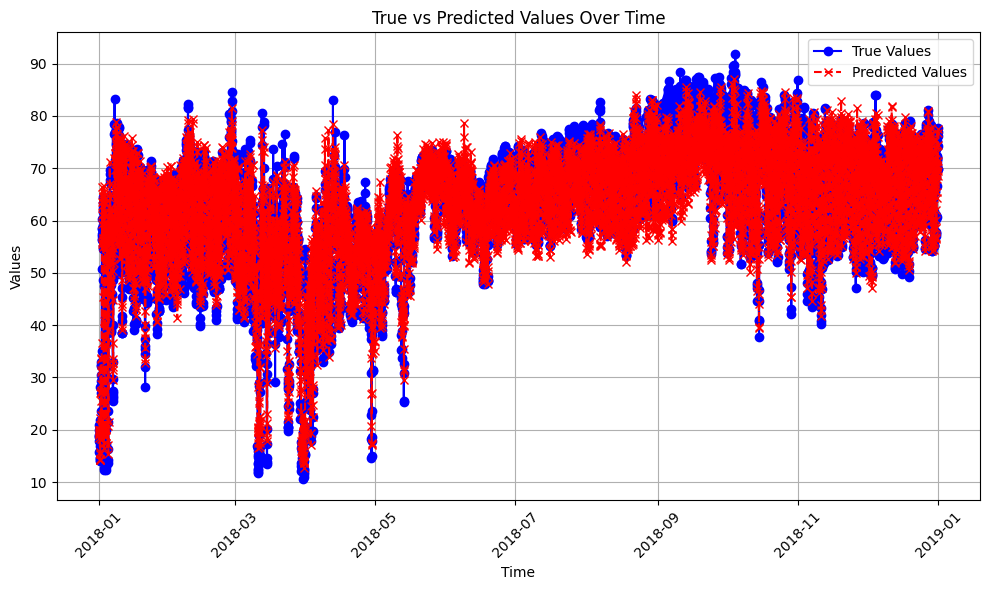

In [23]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(X_test.index, y_price_test, marker='o', color='blue', label='True Values')
plt.plot(X_test.index, y_price_pred, marker='x', color='red', linestyle='--', label='Predicted Values')
plt.title('True vs Predicted Values Over Time')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()